<a href="https://colab.research.google.com/github/EnmaSantos/CSE450/blob/main/starter_signs_v2_student_using_advanced_technique_code_chunks_final-with-holdout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Note: After you run this cell, the training and test data will be available in
# the file browser. (Click the folder icon on the left to view it)
#
# If you don't see the data after the cell completes, click the refresh button
# in the file browser (folder icon with circular arrow)

# First, let's download and unzip the data
!echo "Downloading files..."
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/training1.zip
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/training2.zip
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/holdout.zip
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/mini_holdout.zip
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/mini_holdout_answers.csv

!echo "Unzipping files..."
!unzip -q /content/training1.zip
!unzip -q /content/training2.zip
!unzip -q /content/holdout.zip
!unzip -q /content/mini_holdout.zip

# Combine the two traning directories
!echo "Merging training data..."
!mkdir /content/training
!mv /content/training1/* /content/training
!mv /content/training2/* /content/training

# Cleanup
!echo "Cleaning up..."
!rmdir /content/training1
!rmdir /content/training2
!rm training1.zip
!rm training2.zip
!rm holdout.zip
!rm mini_holdout.zip

!echo "Data ready."

Unzipping files...
Merging training data...
Cleaning up...
Data ready.


In [2]:
# Import libraries
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# We're using keras' ImageDataGenerator class to load our image data.
# See (https://keras.io/api/preprocessing/image/#imagedatagenerator-class) for details
#
# A couple of things to note:
# 1. We're specifying a number for the seed, so we'll always get the same shuffle and split of our images.
# 2. Class names are inferred automatically from the image subdirectory names.
# 3. We're splitting the training data into 80% training, 20% validation.


training_dir = '/content/training/'
image_size = (100, 100)

# Split up the training data images into training and validations sets
# We'll use and ImageDataGenerator to do the splits
# ImageDataGenerator can also be used to do preprocessing and agumentation on the files as can be seen with rescale

train_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=.2
        )
validation_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=.2
        )

train_generator = train_datagen.flow_from_directory(
        training_dir,
        target_size = image_size,
        subset="training",
        batch_size=32,
        class_mode='sparse',
        seed=42,shuffle=True)
validation_generator = validation_datagen.flow_from_directory(
        training_dir,
        target_size=image_size,
        batch_size=32,
        class_mode='sparse',
        subset="validation",
        seed=42)



Found 31368 images belonging to 43 classes.
Found 7841 images belonging to 43 classes.


In [4]:
#these might come in handy
target_names = ['Speed_20', 'Speed_30', 'Speed_50', 'Speed_60', 'Speed_70',
               'Speed_80','Speed_Limit_Ends', 'Speed_100', 'Speed_120', 'Overtaking_Prohibited',
               'Overtakeing_Prohibited_Trucks', 'Crossroad_Ahead', 'Priority_Road_Ahead', 'Yield', 'STOP',
               'Entry_Forbidden', 'Trucks_Forbidden', 'No_Entry(one-way traffic)', 'Cars_Prohibited(!)', 'Left_Curve_Ahead',
               'Right_Curve_Ahead', 'Bends_Left_Then_Right', 'Poor_Surface_Ahead', 'Slippery_Surface_Ahead', 'Road_Narrows_On_Right',
               'Roadwork_Ahead', 'Traffic_Light_Ahead', 'Warning_Pedestrians', 'Warning_Children', 'Warning_Bikes',
               'Uncontrolled_Crossroad', 'Deer_Crossing', 'End_Previous_Limitation', 'Turning_Right_Compulsory', 'Turning_Left_Compulsory',
               'Ahead_Only', 'Straight_Or_Right_Mandatory', 'Straight_Or_Left_Mandatory', 'Passing_Right_Compulsory', 'Passing_Left_Compulsory',
               'Roundabout', 'End_Overtaking_Prohibition', 'End_Overtaking_Prohibition_Trucks']

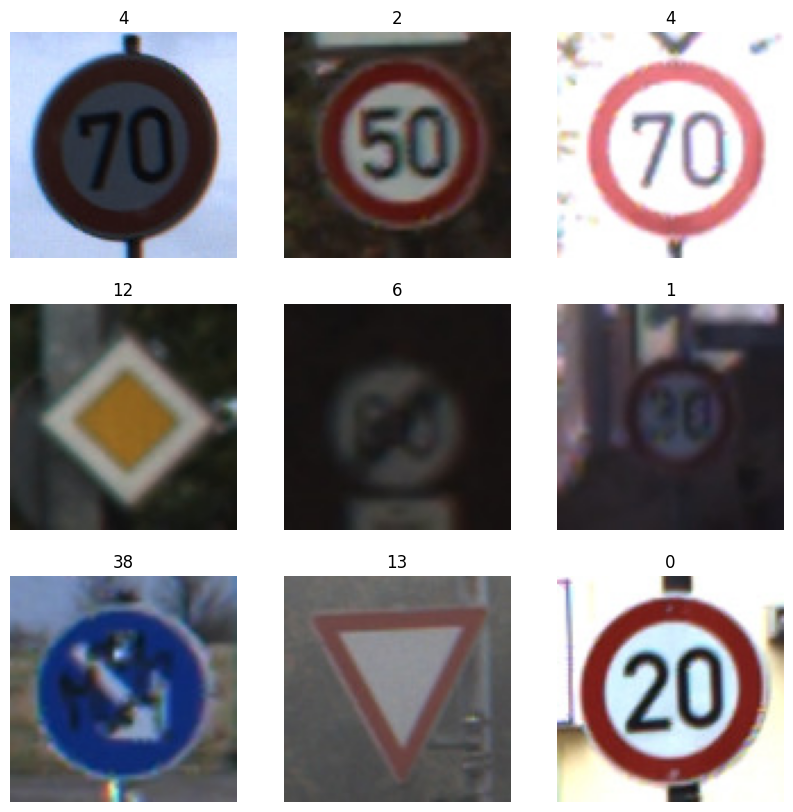

In [5]:
# View 9 images and their class labels
plt.figure(figsize=(10, 10))
images, labels = next(train_generator)  # Assuming train_generator is a generator
batch_size = images.shape[0]

for i in range(min(9, batch_size)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow((images[i] * 255).astype("uint8"))
    plt.title(int(labels[i]))
    plt.axis("off")

plt.show()

In [6]:
# Enhanced data augmentation for traffic sign images
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,        # Slight rotations (traffic signs should still be upright)
    width_shift_range=0.1,    # Small horizontal shifts
    height_shift_range=0.1,   # Small vertical shifts
    zoom_range=0.1,           # Slight zooming in/out
    brightness_range=(0.8, 1.2),  # Brightness variations
    shear_range=5,            # Slight shearing
    fill_mode='nearest',
    validation_split=0.2
)

In [7]:
# We still need basic rescaling for validation data, but no augmentation
validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)


In [8]:
# Update the generators with the new augmentation settings
train_generator = train_datagen.flow_from_directory(
    training_dir,
    target_size=image_size,
    batch_size=32,
    class_mode='sparse',
    subset="training",
    seed=42
)

validation_generator = validation_datagen.flow_from_directory(
    training_dir,
    target_size=image_size,
    batch_size=32,
    class_mode='sparse',
    subset="validation",
    seed=42
)


Found 31368 images belonging to 43 classes.
Found 7841 images belonging to 43 classes.


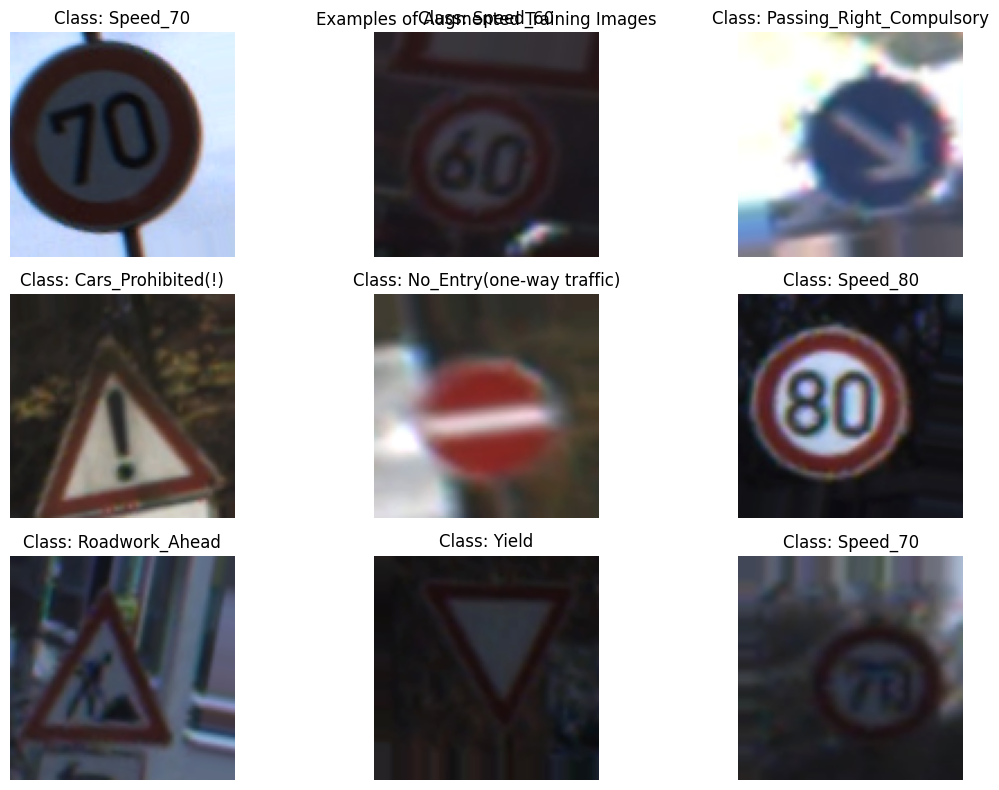

In [9]:
# Visualize some augmented images to verify the augmentation
plt.figure(figsize=(12, 8))
for i in range(9):
    augmented_images, labels = next(train_generator)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0])
    plt.title(f"Class: {target_names[int(labels[0])]}")
    plt.axis("off")
plt.tight_layout()
plt.suptitle("Examples of Augmented Training Images")
plt.show()

In [10]:
# More libraries to further improve the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

In [11]:
# Define a more advanced CNN architecture
improved_model = Sequential([
    # First convolutional block
    Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(100, 100, 3)),
    BatchNormalization(),
    Conv2D(32, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    # Second convolutional block
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    # Third convolutional block
    Conv2D(128, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(128, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),

    # Flatten and dense layers
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(43, activation='softmax')  # 43 classes for German traffic signs
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
# Compile the model with a lower learning rate
improved_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [13]:
# Print model summary
improved_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 100, 100, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 100, 100, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 100, 100, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 100, 100, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 50, 50, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50, 50, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 50, 50, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 50, 50, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 50, 50, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 50, 50, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 25, 25, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 25, 25, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 25, 25, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 25, 25, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 25, 25, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 25, 25, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 9,750,603 (37.20 MB)

 Trainable params: 9,748,683 (37.19 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [14]:
# Define callbacks to improve training
callbacks = [
    # Reduce learning rate when validation accuracy plateaus
    ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    ),

    # Early stopping to prevent overfitting
    EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),

    # Save the best model
    ModelCheckpoint(
        'best_traffic_sign_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

In [15]:
# Train the model with callbacks
history = improved_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,  # We'll use early stopping to determine actual epochs
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.3748 - loss: 2.4042
Epoch 1: val_accuracy improved from -inf to 0.65948, saving model to best_traffic_sign_model.h5


981/981 ━━━━━━━━━━━━━━━━━━━━ 150s 133ms/step - accuracy: 0.3750 - loss: 2.4034 - val_accuracy: 0.6595 - val_loss: 1.1383 - learning_rate: 0.0010
Epoch 2/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.8472 - loss: 0.4782
Epoch 2: val_accuracy improved from 0.65948 to 0.71113, saving model to best_traffic_sign_model.h5


981/981 ━━━━━━━━━━━━━━━━━━━━ 176s 119ms/step - accuracy: 0.8472 - loss: 0.4781 - val_accuracy: 0.7111 - val_loss: 0.9707 - learning_rate: 0.0010
Epoch 3/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.9340 - loss: 0.2098
Epoch 3: val_accuracy improved from 0.71113 to 0.94988, saving model to best_traffic_sign_model.h5


981/981 ━━━━━━━━━━━━━━━━━━━━ 118s 120ms/step - accuracy: 0.9340 - loss: 0.2097 - val_accuracy: 0.9499 - val_loss: 0.1819 - learning_rate: 0.0010
Epoch 4/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.9562 - loss: 0.1412
Epoch 4: val_accuracy improved from 0.94988 to 0.95064, saving model to best_traffic_sign_model.h5


981/981 ━━━━━━━━━━━━━━━━━━━━ 117s 119ms/step - accuracy: 0.9562 - loss: 0.1412 - val_accuracy: 0.9506 - val_loss: 0.1649 - learning_rate: 0.0010
Epoch 5/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.9723 - loss: 0.0888
Epoch 5: val_accuracy did not improve from 0.95064
981/981 ━━━━━━━━━━━━━━━━━━━━ 117s 119ms/step - accuracy: 0.9723 - loss: 0.0888 - val_accuracy: 0.9417 - val_loss: 0.1962 - learning_rate: 0.0010
Epoch 6/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.9729 - loss: 0.0874
Epoch 6: val_accuracy improved from 0.95064 to 0.96875, saving model to best_traffic_sign_model.h5


981/981 ━━━━━━━━━━━━━━━━━━━━ 117s 119ms/step - accuracy: 0.9729 - loss: 0.0874 - val_accuracy: 0.9688 - val_loss: 0.1155 - learning_rate: 0.0010
Epoch 7/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.9804 - loss: 0.0662
Epoch 7: val_accuracy did not improve from 0.96875
981/981 ━━━━━━━━━━━━━━━━━━━━ 118s 120ms/step - accuracy: 0.9804 - loss: 0.0662 - val_accuracy: 0.9603 - val_loss: 0.1420 - learning_rate: 0.0010
Epoch 8/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.9794 - loss: 0.0669
Epoch 8: val_accuracy did not improve from 0.96875
981/981 ━━━━━━━━━━━━━━━━━━━━ 116s 119ms/step - accuracy: 0.9794 - loss: 0.0669 - val_accuracy: 0.9652 - val_loss: 0.1246 - learning_rate: 0.0010
Epoch 9/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.9802 - loss: 0.0650
Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 9: val_accuracy did not improve from 0.96875
981/981 ━━━━━━━━━━━━━━━━━━━━ 116s 118ms/step - accuracy: 0.9802 - loss:

981/981 ━━━━━━━━━━━━━━━━━━━━ 119s 121ms/step - accuracy: 0.9895 - loss: 0.0341 - val_accuracy: 0.9772 - val_loss: 0.1069 - learning_rate: 5.0000e-04
Epoch 11/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.9943 - loss: 0.0205
Epoch 11: val_accuracy did not improve from 0.97717
981/981 ━━━━━━━━━━━━━━━━━━━━ 116s 118ms/step - accuracy: 0.9943 - loss: 0.0205 - val_accuracy: 0.9606 - val_loss: 0.3282 - learning_rate: 5.0000e-04
Epoch 12/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.9940 - loss: 0.0207
Epoch 12: val_accuracy did not improve from 0.97717
981/981 ━━━━━━━━━━━━━━━━━━━━ 117s 119ms/step - accuracy: 0.9940 - loss: 0.0207 - val_accuracy: 0.9676 - val_loss: 0.1270 - learning_rate: 5.0000e-04
Epoch 13/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.9931 - loss: 0.0204
Epoch 13: val_accuracy improved from 0.97717 to 0.98317, saving model to best_traffic_sign_model.h5


981/981 ━━━━━━━━━━━━━━━━━━━━ 116s 119ms/step - accuracy: 0.9931 - loss: 0.0204 - val_accuracy: 0.9832 - val_loss: 0.0558 - learning_rate: 5.0000e-04
Epoch 14/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.9948 - loss: 0.0152
Epoch 14: val_accuracy did not improve from 0.98317
981/981 ━━━━━━━━━━━━━━━━━━━━ 118s 120ms/step - accuracy: 0.9948 - loss: 0.0152 - val_accuracy: 0.9740 - val_loss: 0.0866 - learning_rate: 5.0000e-04
Epoch 15/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.9952 - loss: 0.0163
Epoch 15: val_accuracy did not improve from 0.98317
981/981 ━━━━━━━━━━━━━━━━━━━━ 116s 119ms/step - accuracy: 0.9952 - loss: 0.0163 - val_accuracy: 0.9767 - val_loss: 0.0934 - learning_rate: 5.0000e-04
Epoch 16/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.9940 - loss: 0.0180
Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 16: val_accuracy did not improve from 0.98317
981/981 ━━━━━━━━━━━━━━━━━━━━ 118s 120ms/step - accur

981/981 ━━━━━━━━━━━━━━━━━━━━ 118s 120ms/step - accuracy: 0.9954 - loss: 0.0140 - val_accuracy: 0.9888 - val_loss: 0.0475 - learning_rate: 2.5000e-04
Epoch 18/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.9973 - loss: 0.0079
Epoch 18: val_accuracy did not improve from 0.98878
981/981 ━━━━━━━━━━━━━━━━━━━━ 117s 119ms/step - accuracy: 0.9973 - loss: 0.0079 - val_accuracy: 0.9847 - val_loss: 0.0542 - learning_rate: 2.5000e-04
Epoch 19/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.9981 - loss: 0.0060
Epoch 19: val_accuracy did not improve from 0.98878
981/981 ━━━━━━━━━━━━━━━━━━━━ 118s 120ms/step - accuracy: 0.9981 - loss: 0.0060 - val_accuracy: 0.9824 - val_loss: 0.0744 - learning_rate: 2.5000e-04
Epoch 20/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.9978 - loss: 0.0068
Epoch 20: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 20: val_accuracy did not improve from 0.98878
981/981 ━━━━━━━━━━━━━━━━━━━━ 117s 120ms/step - accur

981/981 ━━━━━━━━━━━━━━━━━━━━ 116s 118ms/step - accuracy: 0.9974 - loss: 0.0079 - val_accuracy: 0.9893 - val_loss: 0.0435 - learning_rate: 1.2500e-04
Epoch 22/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.9976 - loss: 0.0058
Epoch 22: val_accuracy did not improve from 0.98929
981/981 ━━━━━━━━━━━━━━━━━━━━ 116s 118ms/step - accuracy: 0.9976 - loss: 0.0058 - val_accuracy: 0.9889 - val_loss: 0.0415 - learning_rate: 1.2500e-04
Epoch 23/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.9986 - loss: 0.0044
Epoch 23: val_accuracy improved from 0.98929 to 0.98941, saving model to best_traffic_sign_model.h5


981/981 ━━━━━━━━━━━━━━━━━━━━ 117s 119ms/step - accuracy: 0.9986 - loss: 0.0044 - val_accuracy: 0.9894 - val_loss: 0.0389 - learning_rate: 1.2500e-04
Epoch 24/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.9985 - loss: 0.0043
Epoch 24: val_accuracy did not improve from 0.98941
981/981 ━━━━━━━━━━━━━━━━━━━━ 116s 118ms/step - accuracy: 0.9985 - loss: 0.0043 - val_accuracy: 0.9874 - val_loss: 0.0478 - learning_rate: 1.2500e-04
Epoch 25/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.9990 - loss: 0.0034
Epoch 25: val_accuracy did not improve from 0.98941
981/981 ━━━━━━━━━━━━━━━━━━━━ 117s 119ms/step - accuracy: 0.9990 - loss: 0.0034 - val_accuracy: 0.9885 - val_loss: 0.0428 - learning_rate: 1.2500e-04
Epoch 26/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.9987 - loss: 0.0047
Epoch 26: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 26: val_accuracy did not improve from 0.98941
981/981 ━━━━━━━━━━━━━━━━━━━━ 116s 118ms/step - accura

981/981 ━━━━━━━━━━━━━━━━━━━━ 117s 120ms/step - accuracy: 0.9986 - loss: 0.0044 - val_accuracy: 0.9898 - val_loss: 0.0405 - learning_rate: 6.2500e-05
Epoch 28/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.9990 - loss: 0.0046
Epoch 28: val_accuracy did not improve from 0.98980
981/981 ━━━━━━━━━━━━━━━━━━━━ 141s 119ms/step - accuracy: 0.9990 - loss: 0.0046 - val_accuracy: 0.9872 - val_loss: 0.0506 - learning_rate: 6.2500e-05
Epoch 29/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.9989 - loss: 0.0033
Epoch 29: val_accuracy did not improve from 0.98980
981/981 ━━━━━━━━━━━━━━━━━━━━ 118s 120ms/step - accuracy: 0.9989 - loss: 0.0033 - val_accuracy: 0.9876 - val_loss: 0.0449 - learning_rate: 6.2500e-05
Epoch 30/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.9989 - loss: 0.0033
Epoch 30: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 30: val_accuracy did not improve from 0.98980
981/981 ━━━━━━━━━━━━━━━━━━━━ 116s 118ms/step - accur

981/981 ━━━━━━━━━━━━━━━━━━━━ 117s 119ms/step - accuracy: 0.9993 - loss: 0.0022 - val_accuracy: 0.9899 - val_loss: 0.0375 - learning_rate: 7.8125e-06
Epoch 38/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.9990 - loss: 0.0028
Epoch 38: val_accuracy did not improve from 0.98992
981/981 ━━━━━━━━━━━━━━━━━━━━ 117s 119ms/step - accuracy: 0.9990 - loss: 0.0028 - val_accuracy: 0.9898 - val_loss: 0.0395 - learning_rate: 7.8125e-06
Epoch 39/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.9991 - loss: 0.0026
Epoch 39: val_accuracy did not improve from 0.98992
981/981 ━━━━━━━━━━━━━━━━━━━━ 116s 118ms/step - accuracy: 0.9991 - loss: 0.0026 - val_accuracy: 0.9898 - val_loss: 0.0386 - learning_rate: 7.8125e-06
Epoch 40/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.9991 - loss: 0.0021
Epoch 40: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.

Epoch 40: val_accuracy did not improve from 0.98992
981/981 ━━━━━━━━━━━━━━━━━━━━ 117s 119ms/step - accur

981/981 ━━━━━━━━━━━━━━━━━━━━ 118s 120ms/step - accuracy: 0.9992 - loss: 0.0031 - val_accuracy: 0.9906 - val_loss: 0.0385 - learning_rate: 1.9531e-06
Epoch 46/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.9993 - loss: 0.0021
Epoch 46: val_accuracy did not improve from 0.99056
981/981 ━━━━━━━━━━━━━━━━━━━━ 116s 119ms/step - accuracy: 0.9993 - loss: 0.0021 - val_accuracy: 0.9904 - val_loss: 0.0383 - learning_rate: 1.9531e-06
Epoch 47/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.9992 - loss: 0.0025
Epoch 47: val_accuracy did not improve from 0.99056
981/981 ━━━━━━━━━━━━━━━━━━━━ 117s 119ms/step - accuracy: 0.9992 - loss: 0.0025 - val_accuracy: 0.9902 - val_loss: 0.0380 - learning_rate: 1.9531e-06
Epoch 48/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.9992 - loss: 0.0025
Epoch 48: val_accuracy improved from 0.99056 to 0.99069, saving model to best_traffic_sign_model.h5


981/981 ━━━━━━━━━━━━━━━━━━━━ 117s 119ms/step - accuracy: 0.9992 - loss: 0.0025 - val_accuracy: 0.9907 - val_loss: 0.0375 - learning_rate: 1.9531e-06
Epoch 49/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.9994 - loss: 0.0021
Epoch 49: val_accuracy did not improve from 0.99069
981/981 ━━━━━━━━━━━━━━━━━━━━ 116s 118ms/step - accuracy: 0.9994 - loss: 0.0021 - val_accuracy: 0.9895 - val_loss: 0.0379 - learning_rate: 1.9531e-06
Epoch 50/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.9992 - loss: 0.0035
Epoch 50: val_accuracy did not improve from 0.99069
981/981 ━━━━━━━━━━━━━━━━━━━━ 116s 118ms/step - accuracy: 0.9992 - loss: 0.0035 - val_accuracy: 0.9906 - val_loss: 0.0367 - learning_rate: 1.9531e-06
Restoring model weights from the end of the best epoch: 48.


In [16]:
# Plot training history
plt.figure(figsize=(12, 4))

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

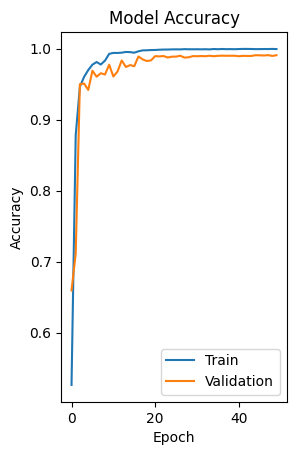

In [17]:
# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

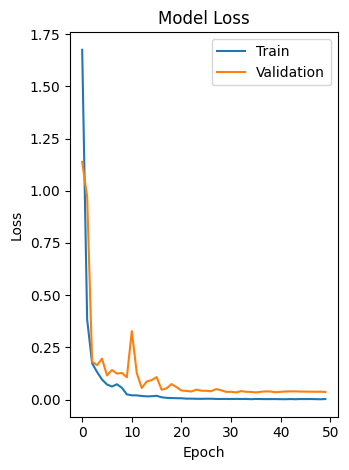

In [18]:
# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

In [19]:
# This is an optional advanced addition to help understand what the model is learning
from tensorflow.keras.models import Model
import cv2
import numpy as np

# Function to create a heatmap of what the CNN is focusing on
def generate_cam(model, img_array, class_idx, layer_name='conv2d_5'):
    # Create a model that will output the last conv layer
    grad_model = Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    # Convert image to array and perform the same preprocessing
    img_array = np.expand_dims(img_array, axis=0)

    # Compute gradient of the predicted class with respect to feature map activations
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_channel = predictions[:, class_idx]

    # Gradient of the class output with respect to the output feature map
    grads = tape.gradient(class_channel, conv_outputs)

    # Vector of mean gradients for each channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Weight feature maps by gradient importance
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)

    # Normalize heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    heatmap = heatmap.numpy()

    # Resize heatmap to original image size
    heatmap = cv2.resize(heatmap, (img_array.shape[2], img_array.shape[1]))

    # Convert to RGB for overlay
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Superimpose heatmap on original image
    superimposed_img = heatmap * 0.4 + img_array[0] * 255
    superimposed_img = np.clip(superimposed_img, 0, 255).astype('uint8')

    return superimposed_img

In [20]:
# Additional imports for evaluation metrics
import os
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

In [21]:
# Step 1: Load the mini holdout dataset
mini_holdout_dir = '/content/'

test_datagen = ImageDataGenerator(rescale=1./255)
mini_holdout_generator = test_datagen.flow_from_directory(
        mini_holdout_dir,
        classes=['mini_holdout'],
        target_size=image_size,
        class_mode=None,
        shuffle=False,
        batch_size=1)

Found 201 images belonging to 1 classes.


In [22]:
# Step 2: Get the filenames from the generator
filenames = mini_holdout_generator.filenames
base_filenames = [os.path.basename(filename) for filename in filenames]
print(f"Number of images in mini_holdout: {len(base_filenames)}")

Number of images in mini_holdout: 201


In [23]:
# Step 3: Load ground truth labels from the CSV file
ground_truth_df = pd.read_csv('/content/mini_holdout_answers.csv')
print("First few rows of the ground truth data:")
print(ground_truth_df.head())
print(f"Number of entries in CSV: {len(ground_truth_df)}")

First few rows of the ground truth data:
    Filename  ClassId
0  00000.jpg       16
1  00001.jpg        1
2  00002.jpg       38
3  00003.jpg       33
4  00004.jpg       11
Number of entries in CSV: 201


In [24]:
# Step 4: Generate predictions with our trained model
# FIXED: Changed 'model' to 'improved_model'
mini_holdout_generator.reset()
mini_holdout_probabilities = improved_model.predict(mini_holdout_generator)
mini_holdout_predictions = [np.argmax(probas) for probas in mini_holdout_probabilities]

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [25]:
# Step 5: Create a DataFrame with predictions and filenames
predictions_df = pd.DataFrame({
    'Filename': base_filenames,
    'Predicted_ClassId': mini_holdout_predictions
})

In [26]:
# Step 6: Merge with ground truth to ensure proper alignment
evaluation_df = pd.merge(ground_truth_df, predictions_df, on='Filename', how='inner')
print(f"Number of matched predictions: {len(evaluation_df)}")

Number of matched predictions: 201


In [27]:
# Step 7: Calculate accuracy
accuracy = accuracy_score(evaluation_df['ClassId'], evaluation_df['Predicted_ClassId'])
print(f"\nModel Accuracy on Mini Holdout Set: {accuracy:.4f} ({accuracy*100:.2f}%)")


Model Accuracy on Mini Holdout Set: 0.9801 (98.01%)


In [28]:
# Step 8: Find the unique classes in the ground truth data
unique_classes = sorted(evaluation_df['ClassId'].unique())
print(f"\nNumber of unique classes in mini holdout: {len(unique_classes)}")
print(f"Classes present: {unique_classes}")


Number of unique classes in mini holdout: 38
Classes present: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 38, 40, 41]


In [29]:
# Create a mapping from class ID to index position for the classification report
present_target_names = [target_names[i] for i in unique_classes]

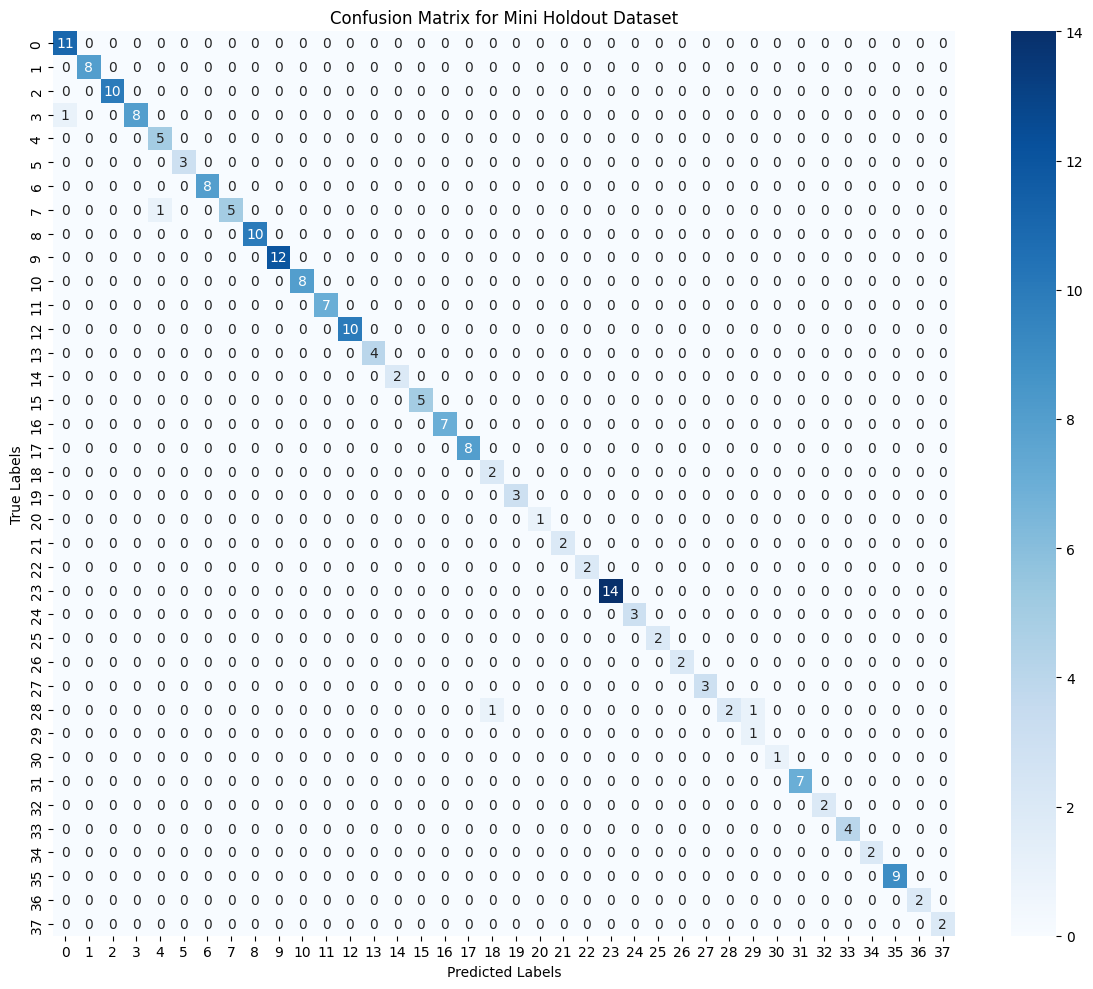

In [30]:
# Step 10: Create and visualize confusion matrix
plt.figure(figsize=(12, 10))
cm = confusion_matrix(
    evaluation_df['ClassId'],
    evaluation_df['Predicted_ClassId'],
    labels=unique_classes  # Use only the classes that are present
)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Mini Holdout Dataset')
plt.tight_layout()
plt.show()


In [31]:
# Step 11: Visualize examples of correct and incorrect predictions
plt.figure(figsize=(20, 16))
count_correct = 0
count_incorrect = 0
examples_to_show = 5

<Figure size 2000x1600 with 0 Axes>

In [32]:
# Create image mapping for easier lookup
mini_holdout_generator.reset()
image_dict = {}
for i, image in enumerate(mini_holdout_generator):
    if i >= len(base_filenames):
        break
    image_dict[base_filenames[i]] = image[0]

Number of unique classes in evaluation dataset: 38
Number of correctly classified unique classes: 38
Number of misclassifications: 4


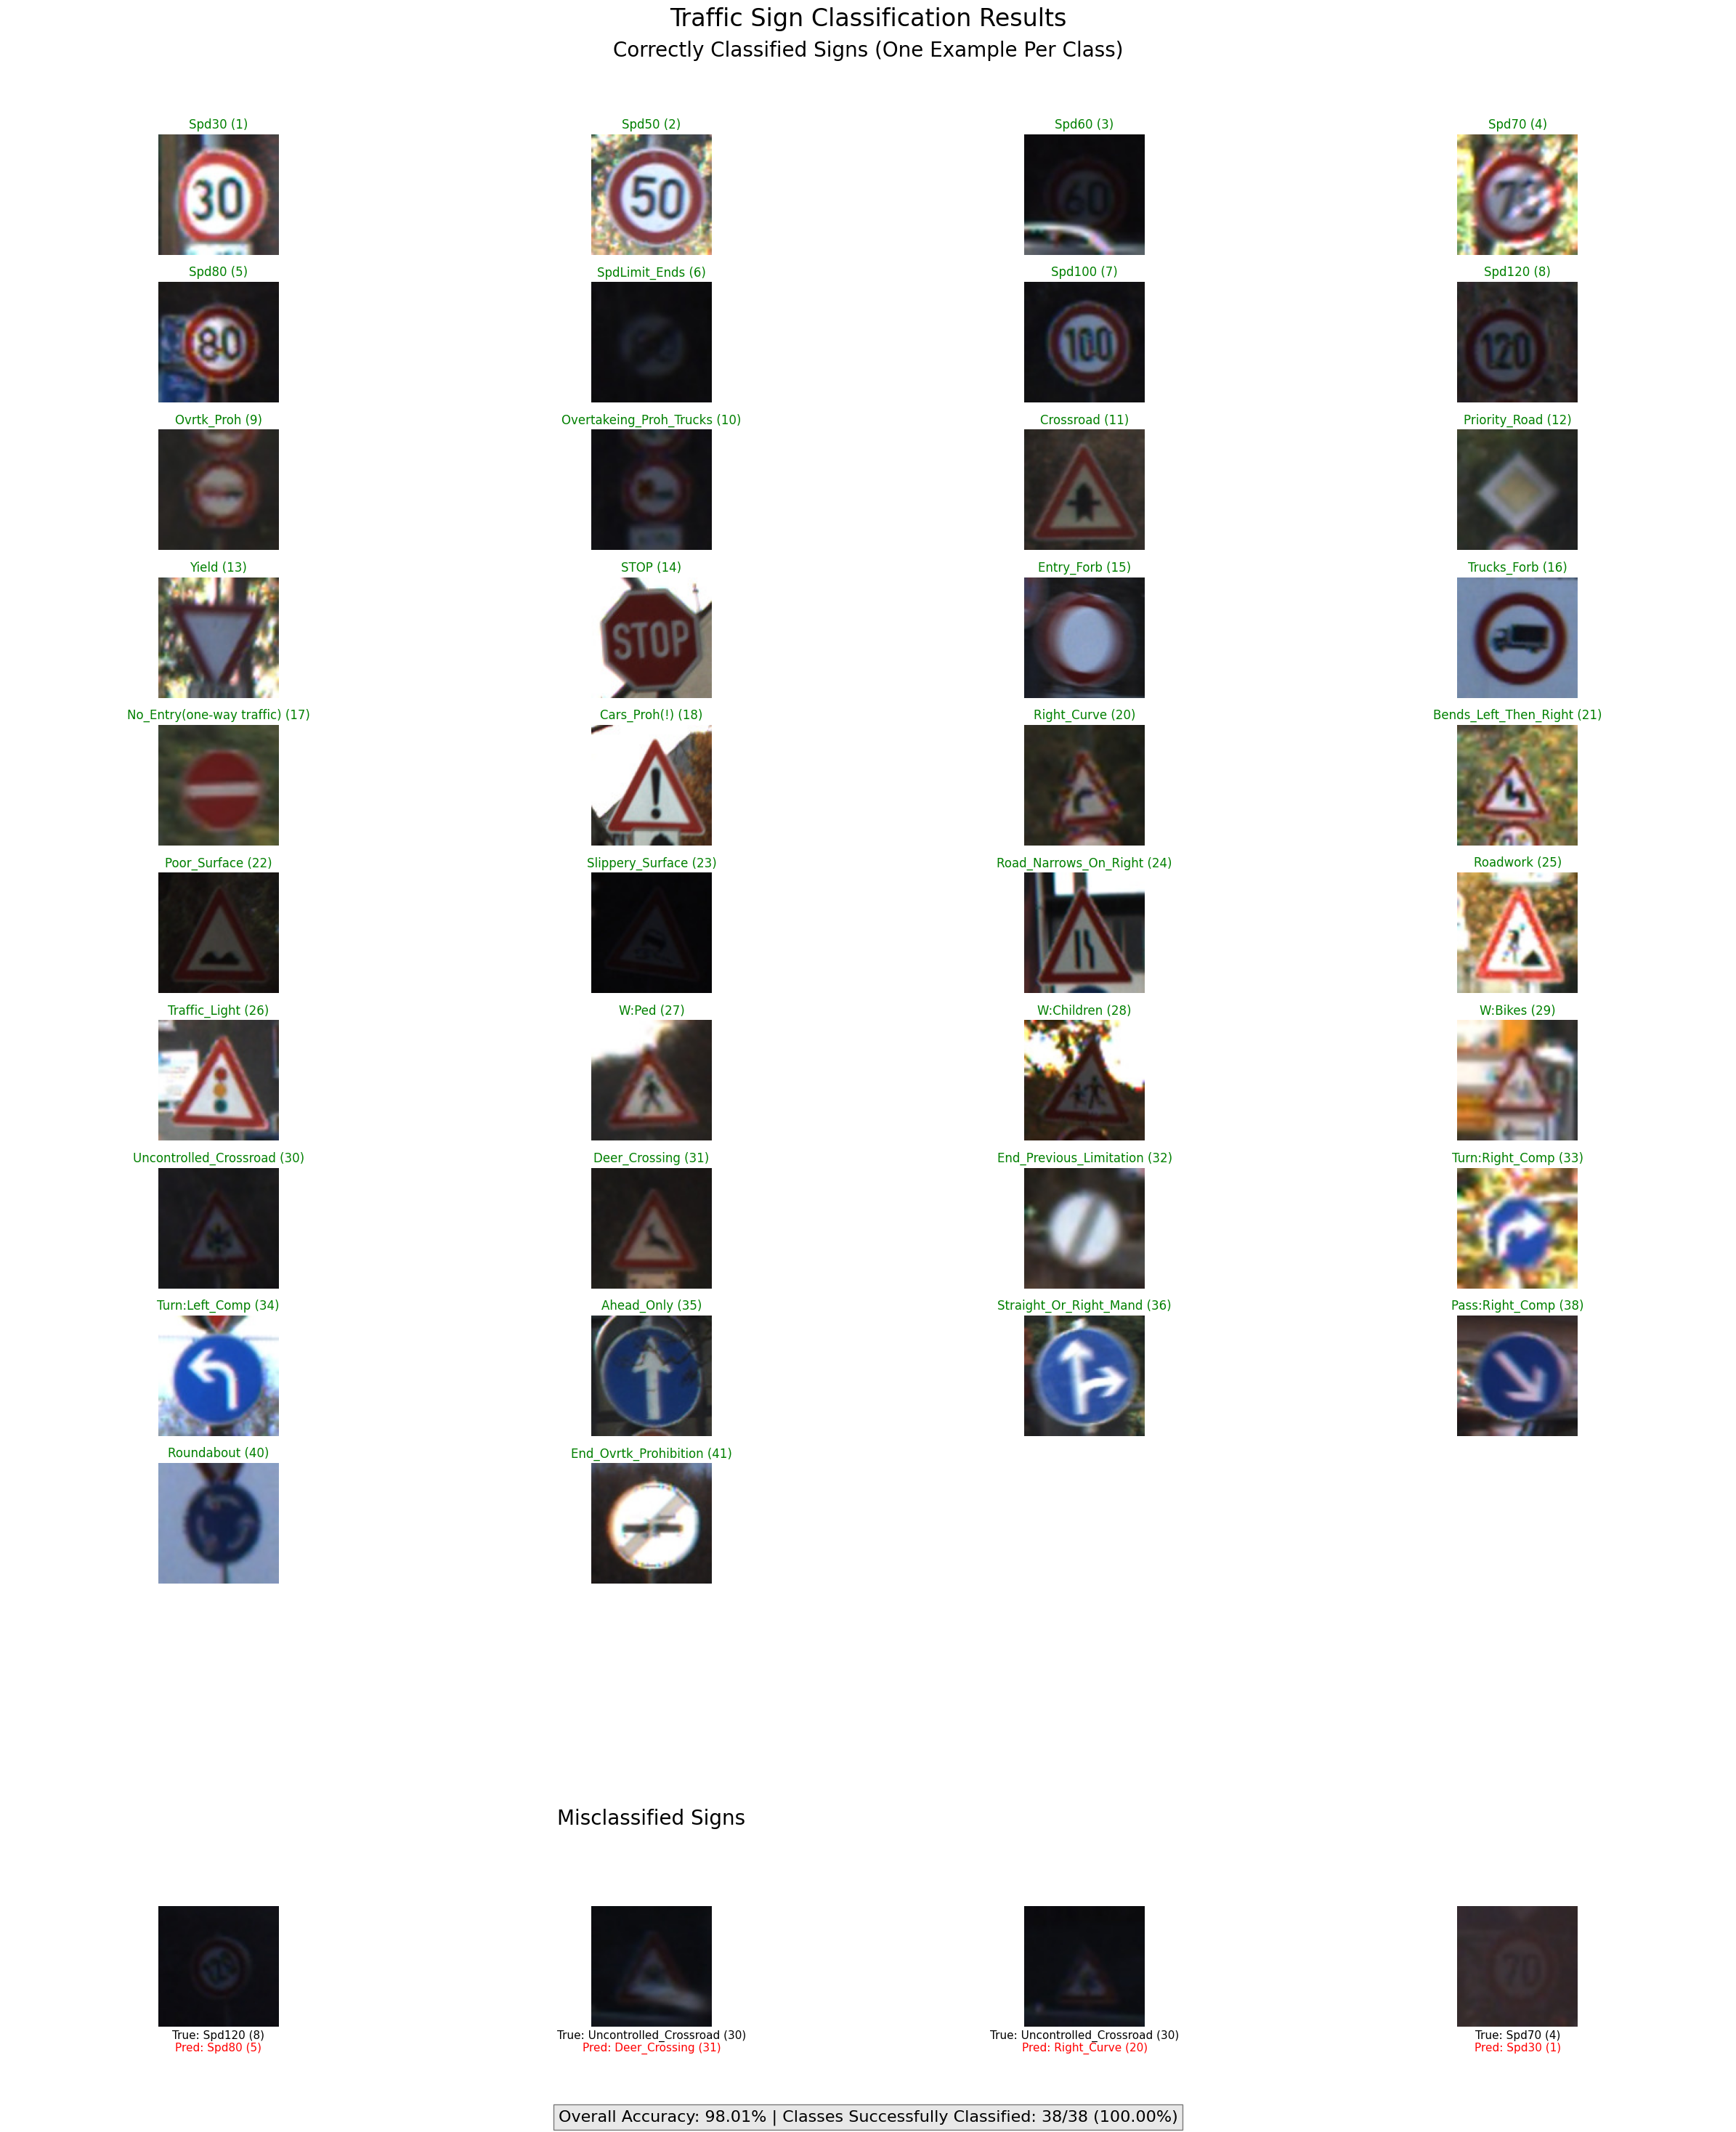

In [33]:
# Comprehensive visualization with LARGER images of each class
plt.figure(figsize=(24, 30))  # Taller figure to accommodate larger images

# Function to create shorter sign names
def shorten_sign_name(name):
    name = name.replace('Warning_', 'W:')
    name = name.replace('Speed_', 'Spd')
    name = name.replace('Compulsory', 'Comp')
    name = name.replace('Roadwork_Ahead', 'Roadwork')
    name = name.replace('Crossroad_Ahead', 'Crossroad')
    name = name.replace('Pedestrians', 'Ped')
    name = name.replace('Turning_', 'Turn:')
    name = name.replace('_Ahead', '')
    name = name.replace('Prohibited', 'Proh')
    name = name.replace('Forbidden', 'Forb')
    name = name.replace('Overtaking', 'Ovrtk')
    name = name.replace('Mandatory', 'Mand')
    name = name.replace('Passing_', 'Pass:')
    return name

# Top section title
plt.suptitle("Traffic Sign Classification Results", fontsize=24, y=0.98)

# Get all unique classes in the evaluation dataset
unique_classes = sorted(evaluation_df['ClassId'].unique())
print(f"Number of unique classes in evaluation dataset: {len(unique_classes)}")

# Create dictionaries to store one example per correctly classified class and all misclassifications
class_examples = {}  # Will hold one example per class: {class_id: (image, class_id)}
incorrect_examples = []  # Will hold all misclassifications

# First pass: collect one example of each correctly classified class and all misclassifications
for _, row in evaluation_df.iterrows():
    is_correct = row['ClassId'] == row['Predicted_ClassId']
    class_id = row['ClassId']

    image = image_dict.get(row['Filename'])
    if image is None:
        continue

    if is_correct:
        # Only store this example if we don't already have one for this class
        if class_id not in class_examples:
            class_examples[class_id] = (image, class_id)
    else:
        # Store all misclassifications
        incorrect_examples.append((image, row['ClassId'], row['Predicted_ClassId']))

# Calculate layout parameters
num_correct_classes = len(class_examples)
print(f"Number of correctly classified unique classes: {num_correct_classes}")
num_incorrect = len(incorrect_examples)
print(f"Number of misclassifications: {num_incorrect}")

# Create explicit section titles
fig = plt.gcf()
fig.text(0.5, 0.96, "Correctly Classified Signs (One Example Per Class)",
         fontsize=20, ha='center', va='center')

# Use fewer columns to make images bigger
correct_cols = 4  # Reduced from 5 to 4
correct_rows = (num_correct_classes + correct_cols - 1) // correct_cols  # Ceiling division

# Create section for correctly classified examples
# Calculate how many subplots we'll need in total
total_subplots = correct_rows * correct_cols

# Display one example per correctly classified class
for i, (class_id, (image, _)) in enumerate(sorted(class_examples.items())):
    if i < total_subplots:  # Make sure we don't go outside our grid
        row = i // correct_cols
        col = i % correct_cols
        position = row * correct_cols + col + 1

        ax = plt.subplot(correct_rows + 3, correct_cols, position)  # +3 rows for misclassifications and buffer
        plt.imshow((image * 255).astype("uint8"))

        # Get the sign name and shorten it
        sign_name = shorten_sign_name(target_names[class_id])
        plt.title(f"{sign_name} ({class_id})", color='green', fontsize=12)  # Larger font
        plt.axis('off')

# Add a divider section with more space
buffer_row = correct_rows + 1
for col in range(correct_cols):
    ax = plt.subplot(correct_rows + 3, correct_cols, buffer_row * correct_cols + col + 1)
    plt.axis('off')
    if col == 1:  # Position adjusted for 4 columns
        plt.text(0.5, 0.5, "Misclassified Signs",
                 fontsize=20, ha='center', va='center', transform=ax.transAxes)

# Display misclassified examples in the last row with larger images
for i, (image, true_id, pred_id) in enumerate(incorrect_examples):
    if i < correct_cols:  # Only show up to 4 misclassifications (to match columns)
        position = (buffer_row + 1) * correct_cols + i + 1
        ax = plt.subplot(correct_rows + 3, correct_cols, position)
        plt.imshow((image * 255).astype("uint8"))

        # Place labels below the image
        true_name = shorten_sign_name(target_names[true_id])
        pred_name = shorten_sign_name(target_names[pred_id])

        plt.text(0.5, -0.10, f"True: {true_name} ({true_id})",
                color='black', fontsize=11, ha='center', transform=ax.transAxes)
        plt.text(0.5, -0.20, f"Pred: {pred_name} ({pred_id})",
                color='red', fontsize=11, ha='center', transform=ax.transAxes)
        plt.axis('off')

# If we have fewer than 4 incorrect examples, add a note
if num_incorrect < correct_cols:
    position = (buffer_row + 1) * correct_cols + num_incorrect + 1
    ax = plt.subplot(correct_rows + 3, correct_cols, position)
    plt.text(0.5, 0.5, f"Only {num_incorrect} misclassifications\nfound in the evaluation set!",
            horizontalalignment='center', verticalalignment='center', fontsize=14)  # Larger font
    plt.axis('off')

# Add performance metrics as text at the bottom
overall_accuracy = len(evaluation_df[evaluation_df['ClassId'] == evaluation_df['Predicted_ClassId']]) / len(evaluation_df)
class_coverage = len(class_examples) / len(unique_classes) if unique_classes else 0

metrics_text = (
    f"Overall Accuracy: {overall_accuracy:.2%} | "
    f"Classes Successfully Classified: {len(class_examples)}/{len(unique_classes)} ({class_coverage:.2%})"
)

plt.figtext(0.5, 0.01, metrics_text,
            ha="center", fontsize=16, bbox={"facecolor":"lightgray", "alpha":0.5, "pad":5})  # Larger font

# Adjust spacing for clarity and to reduce crowding
plt.subplots_adjust(hspace=0.8, wspace=0.4)  # More space between plots
plt.tight_layout(rect=[0, 0.04, 1, 0.95])
plt.show()

In [34]:

plt.suptitle("Examples of Correct (top) and Incorrect (bottom) Predictions", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

<Figure size 640x480 with 0 Axes>

In [35]:
# Step 12: Analyze which sign types have the highest error rates
evaluation_df['is_correct'] = evaluation_df['ClassId'] == evaluation_df['Predicted_ClassId']
error_df = evaluation_df[~evaluation_df['is_correct']]

<ipython-input-36-975ce10477bb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  error_df['true_sign_name'] = error_df['ClassId'].map(lambda x: target_names[x])



Sign types with the highest error counts:
true_sign_name
Uncontrolled_Crossroad    2
Speed_120                 1
Speed_70                  1
Name: count, dtype: int64


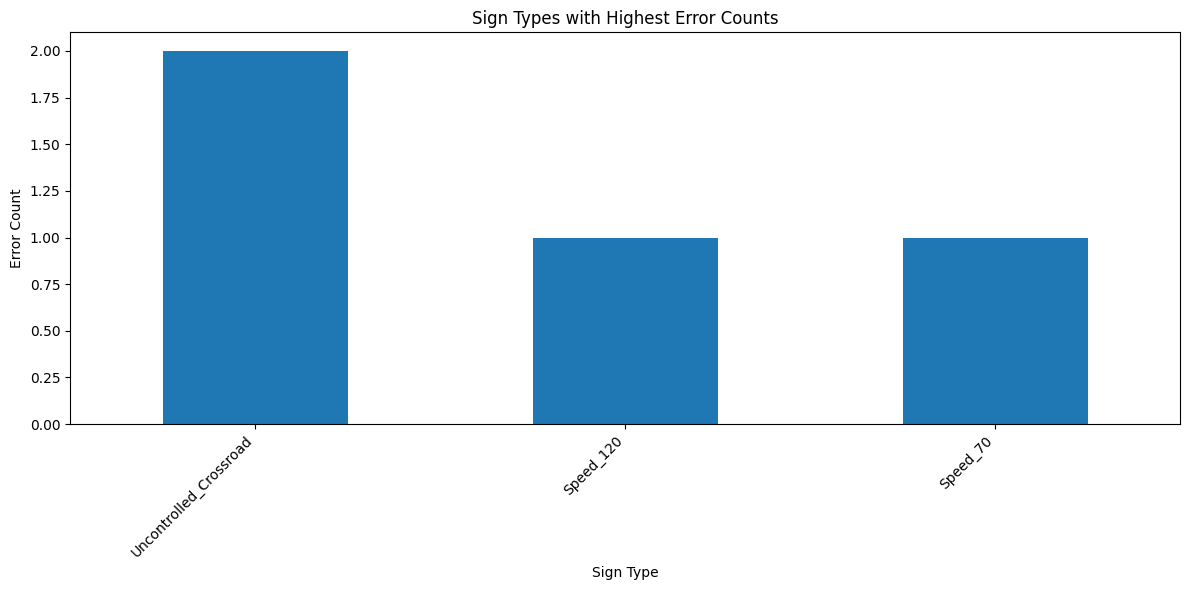

In [36]:
if len(error_df) > 0:
    # Map class IDs to their names
    error_df['true_sign_name'] = error_df['ClassId'].map(lambda x: target_names[x])

    # Count errors by sign type
    error_counts = error_df['true_sign_name'].value_counts()

    print("\nSign types with the highest error counts:")
    print(error_counts.head(10))

    # Create a bar chart of the most frequently misclassified signs
    plt.figure(figsize=(12, 6))
    error_counts.head(min(10, len(error_counts))).plot(kind='bar')
    plt.title('Sign Types with Highest Error Counts')
    plt.xlabel('Sign Type')
    plt.ylabel('Error Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [37]:
# Make sure there's no indentation at the beginning of this line
if len(error_df) > 5:  # Only if we have enough errors to analyze
    error_df['pred_sign_name'] = error_df['Predicted_ClassId'].map(lambda x: target_names[x])
    confusion_pairs = error_df.groupby(['true_sign_name', 'pred_sign_name']).size()
    confusion_pairs = confusion_pairs.sort_values(ascending=False)

    print("\nMost common confusion patterns:")
    print(confusion_pairs.head(min(10, len(confusion_pairs))))
    print("\nThese patterns indicate which signs are most frequently confused with each other.")

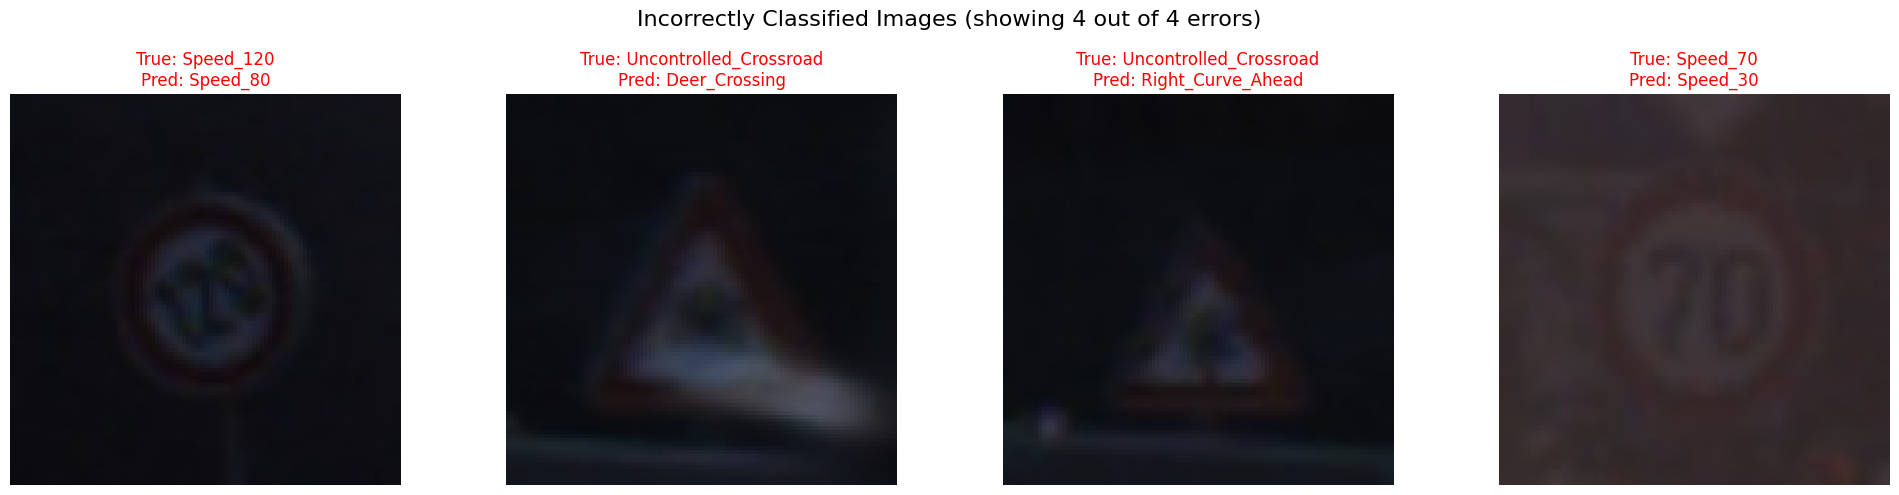


Errors grouped by true sign type:
Speed_70: 1 errors
Speed_120: 1 errors
Uncontrolled_Crossroad: 2 errors

Detailed confusion patterns:
Speed_120 mistaken as Speed_80: 1 times
Speed_70 mistaken as Speed_30: 1 times
Uncontrolled_Crossroad mistaken as Deer_Crossing: 1 times
Uncontrolled_Crossroad mistaken as Right_Curve_Ahead: 1 times


In [38]:
# This code should be added after running the model and generating predictions

# Create a detailed visualization of incorrectly classified images
def visualize_errors(evaluation_df, image_dict, target_names, max_examples=20):
    """
    Creates a detailed visualization of incorrectly classified images

    Parameters:
    evaluation_df - DataFrame with true and predicted classes
    image_dict - Dictionary mapping filenames to image data
    target_names - List of class names
    max_examples - Maximum number of examples to display
    """
    # Filter for incorrect predictions only
    error_df = evaluation_df[evaluation_df['ClassId'] != evaluation_df['Predicted_ClassId']].copy()

    # Get the number of errors to display (up to max_examples)
    num_errors = min(len(error_df), max_examples)

    if num_errors == 0:
        print("No errors found! The model correctly classified all images.")
        return

    # Calculate grid dimensions
    cols = 4  # 4 images per row
    rows = (num_errors + cols - 1) // cols  # Ceiling division

    # Create a larger figure to accommodate more images
    plt.figure(figsize=(20, 5 * rows))

    # Add each incorrect prediction to the plot
    for i, (_, row) in enumerate(error_df.head(num_errors).iterrows()):
        if i >= max_examples:
            break

        # Get the image
        image = image_dict.get(row['Filename'])
        if image is None:
            continue

        # Create subplot
        plt.subplot(rows, cols, i + 1)
        plt.imshow((image * 255).astype("uint8"))

        # Get true and predicted class names
        true_name = target_names[row['ClassId']]
        pred_name = target_names[row['Predicted_ClassId']]

        # Display detailed information
        plt.title(f"True: {true_name}\nPred: {pred_name}", color='red')
        plt.xlabel(f"Filename: {row['Filename']}")
        plt.axis('off')

    plt.suptitle(f"Incorrectly Classified Images (showing {num_errors} out of {len(error_df)} errors)",
                fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    # Additionally, group errors by true class for analysis
    print("\nErrors grouped by true sign type:")
    error_class_counts = error_df.groupby('ClassId').size()
    for class_id, count in error_class_counts.items():
        print(f"{target_names[class_id]}: {count} errors")

    # Show confusion patterns (what signs get confused with what)
    print("\nDetailed confusion patterns:")
    error_df['true_sign_name'] = [target_names[x] for x in error_df['ClassId']]
    error_df['pred_sign_name'] = [target_names[x] for x in error_df['Predicted_ClassId']]

    confusion_patterns = error_df.groupby(['true_sign_name', 'pred_sign_name']).size()
    for (true_name, pred_name), count in confusion_patterns.items():
        print(f"{true_name} mistaken as {pred_name}: {count} times")

# Call this function to visualize errors
visualize_errors(evaluation_df, image_dict, target_names, max_examples=20)

In [40]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Ensure image_size matches what you used for training
image_size = (100, 100)

# Set up the test data generator
test_dir = '/content/'
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        classes=['holdout'],
        target_size=image_size,
        class_mode=None,  # Set to None to only get images without labels
        batch_size=32,
        shuffle=False)

# Make predictions using your improved_model
probabilities = improved_model.predict(test_generator)
predictions = [np.argmax(probas) for probas in probabilities]

# Get the filenames to create the submission file
filenames = [f.split('/')[-1] for f in test_generator.filenames]

# Create a pandas DataFrame for submission
import pandas as pd
submission_df = pd.DataFrame({
    'Filename': filenames,
    'ClassId': predictions
})

# Save to CSV
submission_df.to_csv('holdout_predictions.csv', index=False)
print("Predictions saved to 'holdout_predictions.csv'")

Found 12630 images belonging to 1 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


395/395 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step
Predictions saved to 'holdout_predictions.csv'


In [43]:
import random

# Get random sample of filenames and their predictions
sample_size = 50
sample_indices = random.sample(range(len(filenames)), sample_size)

for idx in sample_indices:
    print(f"File: {filenames[idx]}, Predicted Class: {predictions[idx]}")

File: 06445.jpg, Predicted Class: 11
File: 07055.jpg, Predicted Class: 10
File: 10033.jpg, Predicted Class: 8
File: 01150.jpg, Predicted Class: 32
File: 05680.jpg, Predicted Class: 10
File: 00787.jpg, Predicted Class: 10
File: 04003.jpg, Predicted Class: 2
File: 04667.jpg, Predicted Class: 40
File: 08190.jpg, Predicted Class: 5
File: 04050.jpg, Predicted Class: 29
File: 07587.jpg, Predicted Class: 5
File: 06813.jpg, Predicted Class: 6
File: 08522.jpg, Predicted Class: 9
File: 09323.jpg, Predicted Class: 4
File: 08147.jpg, Predicted Class: 34
File: 04564.jpg, Predicted Class: 1
File: 02376.jpg, Predicted Class: 4
File: 08205.jpg, Predicted Class: 42
File: 11183.jpg, Predicted Class: 26
File: 04286.jpg, Predicted Class: 5
File: 01787.jpg, Predicted Class: 5
File: 04068.jpg, Predicted Class: 36
File: 08353.jpg, Predicted Class: 38
File: 05783.jpg, Predicted Class: 14
File: 06747.jpg, Predicted Class: 35
File: 10930.jpg, Predicted Class: 1
File: 06589.jpg, Predicted Class: 17
File: 00270.j